# Искусственные нейронные сети в PyTorch

На основе примитивов для операций над тензорами и инфраструктуры автоматического дифференцирования в PyTorch определены и базовые конструкции, позволяющие создавать и обучать нейронные сети (в первую очередь - это модуль `torch.nn`). В частности, PyTorch предлагает и базовую реализацию части тех классов, которые были самостоятельно "придуманы" и определены выше, например:

- основные функции потерь: `torch.nn.MSELoss` (среднеквадратичная ошибка), `torch.nn.CrossEntropy` (кросс-энтропия) и др.;
- оптимизаторы: `torch.optim.SGD` (стохастический градиентный спуск), `torch.optim.Adam` (Adam - adaptive moment estimation) и др.;

Особого внимания заслуживает базовый класс `nn.Module`, предоставляющий основу для создания пользовательских нейронных сетей. Любая нейросетевая модель должна быть унаследована от `nn.Module`, что обеспечивает простоту взаимодействия с другими компонентами фреймворка.

Воспроизведем пример выше, но уже используя более сложную "неизвестную" функцию и инструменты для создания и обучения нейронных сетей, предлагаемые PyTorch.


In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

Создадим набор данных, порожденный некоторой линейной функцией $y = k x + b$. Для модели регрессии эта функция будет неизвестна, ее "угадывание" или восстановление как раз и будет происходить в ходе обучения регрессионной модели. 

In [2]:
def true_fun(x):
    return np.where(x < 0.5, np.sin(9.5*x)/2 + 0.5, (x - 0.5) ** 2)

# Параметр, контролирующий шум, добавляемый к сгенерированным данным
# (чтобы они отклонялись от уравнения, заданного в `true_fun`)
NOISE_SIGMA = 0

In [3]:
x = np.random.random(80)
y = true_fun(x) + np.random.normal(0, NOISE_SIGMA, x.shape)

Вспомогательная функция для визуализации набора (и модели):

In [4]:
def plot(x, y, foo=None):
    plt.scatter(x, y)
    if foo is not None:
        x_ = np.arange(0, 1.0, 0.05).reshape(-1, 1)
        y_ = foo(torch.from_numpy(x_).to(torch.float32)).numpy(force=True).ravel()
        plt.plot(x_, y_, color='orange')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])

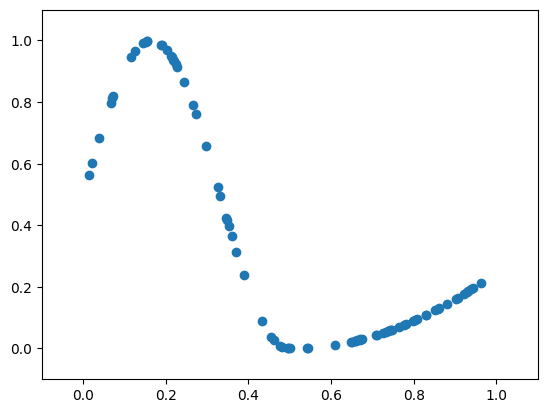

In [5]:
plot(x, y)

Определим класс `NeuralModel`, инкапсулирующий в себе нейросетевую модель, включающую один скрытый слой, состоящий из нескольких нейронов. Класс `NeuralModel` должен быть наследником `nn.Module`, а в качестве полей содержит набор преобразований исходных данных. Собственно параметры, изменение которых происходит во время обучения, находятся "внутри" `nn.Linear` (линейные полносвязные слои).

In [6]:
class NeuralModel(nn.Module):
   
    def __init__(self):
        super().__init__()
        # Слой обработки исходных данных
        self.fc = nn.Linear(1, 3)
        # Функция активации ReLU
        self.relu = nn.ReLU()
        # Слой формирования выходного значения
        self.output = nn.Linear(3, 1)

    def forward(self, x):
        """Вычисление значения модели для заданного аргумента."""
        x = self.fc(x)
        x = self.relu(x)
        x = self.output(x)
        return x


In [7]:
# Создадим экземпляр модели
model = NeuralModel()
# Создадим экземпляр оптимизатора, связав его с
# параметрами оцениваемой нейросетевой модели
optimizer = torch.optim.Adam(model.parameters())
# Функция потерь
loss_fn = nn.MSELoss()

# Исходные данные для обучения следует преобразовать
# в тензоры. По сравнению с предыдущим примером, здесь имеет смысл
# обратить внимание на два момента:
#   1. преобразование формы входного тензора - чтобы все 
#      нейросетевые модули вели себя ожидаемо, первым измерением
#      должны быть образцы, а остальными - описание этих образцов
#   2. тип должен быть torch.float32
#
x_tensor = torch.from_numpy(x.reshape(-1, 1)).to(torch.float32)
y_tensor = torch.from_numpy(y.reshape(-1, 1)).to(torch.float32)

In [8]:
prev_loss = 1000.0

while True:
    # Сбросим градиент (чтобы результаты предыдущей
    # итерации не влияли на направление изменения параметров)
    optimizer.zero_grad()
    # Получим предсказания
    y_hat = model(x_tensor)
    # Вычислим ошибку предсказаний модели
    loss = loss_fn(y_hat, y_tensor)
    print(loss.item())
    # Вычислим градиент ошибки предсказаний модели по всем
    # параметрам
    loss.backward()
    # Скорректируем значения параметров
    optimizer.step()
    # Условие останова - если ошибка перестает быстро уменьшаться
    if abs(prev_loss - loss) < 1e-5:
        break
    prev_loss = loss.detach()

0.3565172553062439
0.3550294041633606
0.35355061292648315
0.3520810604095459
0.3506210446357727
0.3491707444190979
0.347730427980423
0.3463002145290375
0.34487298130989075
0.3434528410434723
0.34204310178756714
0.340643972158432
0.33925214409828186
0.3378638029098511
0.33648645877838135
0.33512037992477417
0.33376574516296387
0.3324228525161743
0.33109185099601746
0.32977294921875
0.3284662365913391
0.32717183232307434
0.3258897662162781
0.3246200978755951
0.32336288690567017
0.3221181035041809
0.3208857476711273
0.31966572999954224
0.3184579908847809
0.3172623813152313
0.3160788416862488
0.3149072527885437
0.3137473464012146
0.3125903010368347
0.3114425539970398
0.310305655002594
0.3091793358325958
0.3080635964870453
0.3069581389427185
0.3058629035949707
0.3047775626182556
0.30370187759399414
0.3026356101036072
0.30157849192619324
0.30053022503852844
0.29949042201042175
0.29845887422561646
0.2974351942539215
0.2964191436767578
0.29541030526161194
0.29440850019454956
0.2934132814407348

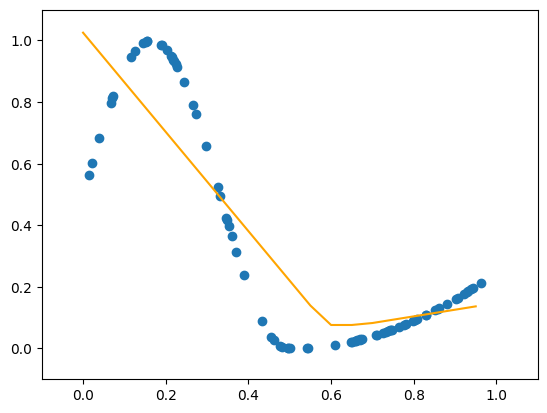

In [9]:
plot(x, y, model)

Процесс обучения прошел, но и значение функции потерь достаточно высокое, и визуально выученная гипотеза далека от "задуманной". Это характерно для ситуации, когда модель (нейросетевая гипотеза) оказывается недостаточно выразительной для представления эмпирических данных. Увеличение мощности нейросетевой модели может быть достигнуто увеличением количества и размера слоев:

In [10]:
class ImprovedNeuralModel(nn.Module):
   
    def __init__(self, n_hidden_layers, neurons_per_layer):
        super().__init__()
        layers = []
        for i in range(n_hidden_layers):
            if i == 0:
                layers.append(nn.Linear(1, neurons_per_layer))
            else:
                layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(neurons_per_layer, 1))
        # nn.Sequential - специальный модуль, который обеспечивает
        # последовательное применение набора модулей к переданным
        # входным данным
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """Вычисление значения модели для заданного аргумента."""
        return self.layers(x)


In [11]:
print(ImprovedNeuralModel(2, 3))

ImprovedNeuralModel(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)


In [12]:
model = ImprovedNeuralModel(5, 20)
optimizer = torch.optim.Adam(model.parameters())

prev_loss = 1000.0

while True:
    # Сбросим градиент (чтобы результаты предыдущей
    # итерации не влияли на направление изменения параметров)
    optimizer.zero_grad()
    # Получим предсказания
    y_hat = model(x_tensor)
    # Вычислим ошибку предсказаний модели
    loss = loss_fn(y_hat, y_tensor)
    print(loss.item())
    # Вычислим градиент ошибки предсказаний модели по всем
    # параметрам
    loss.backward()
    # Скорректируем значения параметров
    optimizer.step()
    # Условие останова - если ошибка перестает быстро уменьшаться
    if abs(prev_loss - loss) < 1e-5:
        break
    prev_loss = loss.detach()


0.14845725893974304
0.14721015095710754
0.1460188329219818
0.1448785960674286
0.1437833607196808
0.14274147152900696
0.14175885915756226
0.14087410271167755
0.14007484912872314
0.13930851221084595
0.13859179615974426
0.13793030381202698
0.13731113076210022
0.13673418760299683
0.1361975371837616
0.13569961488246918
0.13523419201374054
0.1347949206829071
0.13437049090862274
0.13395662605762482
0.13354678452014923
0.1331336945295334
0.13271227478981018
0.13227704167366028
0.13182048499584198
0.13133634626865387
0.13081757724285126
0.1302611082792282
0.1296617090702057
0.12901614606380463
0.12832069396972656
0.12757310271263123
0.12677481770515442
0.12592090666294098
0.12501481175422668
0.12406076490879059
0.12305431067943573
0.1219928115606308
0.12086975574493408
0.11968083679676056
0.1184229850769043
0.11708949506282806
0.11567896604537964
0.11418554931879044
0.11260952055454254
0.1109444722533226
0.10918758064508438
0.10731090605258942
0.10530205816030502
0.10311093181371689
0.100698389

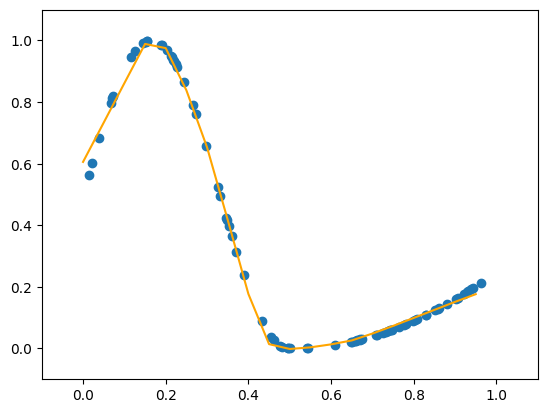

In [13]:
plot(x, y, model)